In [134]:
using DifferentialEquations, ParameterizedFunctions, CairoMakie

vdp = @ode_def begin
    dx = (x - x^3/3 + y)/ϵ
    dy = (a-x)
end ϵ a

function vdpplot(u0,tspan,p)
    prob = ODEProblem(vdp, u0, tspan, p)
    sol = solve(prob,abstol=1e-12,reltol=1e-12)
    
    fig = Figure()
    ax = Axis(fig[1,1])
    
    lines!(ax, -2.5:.01:2.5, x->-x+x^3/3,label="x' = 0", color=:red)
    lines!(ax, ones(length(-1:.1:1))*p[2],-1:.1:1,  label="y' = 0", color=:green)
    lines!(ax,sol[1,:],sol[2,:],color=:blue)
    ylims!(-1,1)
    axislegend()

    fig,sol
end

canard_a = .99874045124555;

gsvf = @ode_def begin
    da = μ-a-a*b^2
    db = (-b+a+a*b^2)/ϵ
end ϵ μ

function gstr(u0,tspan,p)
    prob = ODEProblem(gsvf, u0, tspan, p)
    sol = solve(prob,abstol=1e-12,reltol=1e-12)
    sol
end


gstr (generic function with 1 method)

# Topics in multiscale dynamics, with applications - Day 2

### Fast-slow systems, Fenichel theory, and blowups

## I. Fast-slow systems

* An $(m,n)$**-fast-slow system** is an ODE of the form $$\frac{dx}{dt} = f(x, y, \epsilon)$$ $$\frac{dy}{dt} = \epsilon g(x,y,\epsilon)$$ where $(x,y) \in \mathbb{R}^m \times \mathbb{R}^n$ and $0 < \epsilon \ll 1$ is a small parameter representing the ratio of timescales. Note that the variables $y$ are _slow_ and the variables $x$ are _fast_. 

    * E.g. the van der Pol oscillator we looked at last time is a $(1,1)$-fast-slow system.

* We consider two timescales: the _slow timescale_ $\tau$ and the _fast timescale_ $t$, related by the equation $t = \tau/\epsilon$. In the above formulation, the derivative is taken with respect to fast time. We could change variables to the slow timescale to obtain $$\epsilon \frac{dx}{d\tau} = f(x,y,\epsilon)$$ $$\frac{dy}{d\tau} = g(x,y,\epsilon)$$ This system is _equivalent_ to the original system for $\epsilon \neq 0$.

* One way to think about what the timescales mean: rescale time such that the fast resp. slow motions are $\mathcal{O}(1)$ w.r.t $\epsilon$. In fast time, the $\mathcal{O}(1)$ fast variables are "observable" while the $\mathcal{O}(\epsilon)$ slow variables are "too slow to be observed"; in slow time, the $\mathcal{O}(1/\epsilon)$ fast variables are "too fast to be observed" while the $\mathcal{O}(1)$ slow variables are "observable".



### Two distinguished singular limits

* The main idea of geometric singular perturbation theory (GSPT) is to analyze fast-slow systems by studying two distinguished **singular limits** as $\epsilon \to 0$:
    * When working in fast time, taking $\epsilon \to 0$ gives the system $$\frac{dx}{dt} = f(x,y, 0)$$ $$\frac{dy}{dt} = 0$$ This limiting $m$-dimensional system is called the **fast subsystem** or **layer problem**. In this limit, the fully constant $y$ variables act as parameters for the equation governing $x$ dynamics; thus, understanding the fast subsystem amounts to solving a bifurcation problem.
    * When working in slow time, taking $\epsilon \to 0$ gives the system $$0 = f(x,y,0)$$ $$\frac{dy}{d\tau} = g(x,y,0)$$ This limiting $n$-dimensional system is called the **slow subsystem** or **algebraic problem**. In this limit, we have a _differential algebraic equation_ -- the trajectory is constrained to lie on the manifold $f = 0$. 
    * The manifold $f = 0$ is called the **critical manifold**; note that points on the critical manifold are precisely the equilibria of the layer problem.

* The hope is ultimately to use analysis of the singular limits to obtain results for $\epsilon$ sufficiently small but nonzero; it will be important to understand the conditions under which we actually accomplish this.

* Crucially, both the layer and algebraic problems are of _lower dimension_ than the original problem, providing a significant dimensionality reduction.

* **Convention moving forward:** the derivative w.r.t slow time will be denoted by an overdot $(\dot{x})$, the derivative w.r.t fast time will be denoted by a prime $(x')$.


### Example: the van der Pol oscillator

Recall the example of a van der Pol oscillator, with equations $$x' = x - \frac{x^3}{3} + y$$ $$y' = \epsilon\cdot(a-x)$$ when written in fast time, and equations $$\epsilon \dot{x} = x - \frac{x^3}{3} + y$$ $$\dot{y} =a-x$$ when written in slow time. 

**_Algebraic problem_/_slow subsystem_**

The algebraic problem is $$x - \frac{x^3}{3} + y = 0 $$ $$\dot{y} = a-x$$ Differentiating the algebraic equation w.r.t slow time gives $$\dot{x} - x^2 \dot{x} + a-x = 0 \implies \dot{x} = \frac{x-a}{1-x^2}$$ Note that the algebraic problem has singularities at $x = \pm 1$, which are precisely the folds of the cubic.

**_Reduced problem_/_fast subsystem_**

The reduced problem is given by the one-parameter family of vector fields on $\mathbb{R}$ defined by $$\dot{x} = x - \frac{x^3}{3} + y$$ $$\dot{y} = 0$$ For any particular value of $y$, the system has 1, 2, or 3 equilibria (generically 1 or 3, only 2 equilibria at the saddle-node bifurcations occurring at the local max and min of the cubic). The left and right branches of the cubic are comprised of attracting, hyperbolic equilibria of their respective layers, while the middle branch is comprised of repelling, hyperbolic equilibria. The two knees of the cubic correspond to _nonhyperbolic_ equilibria of their layers.

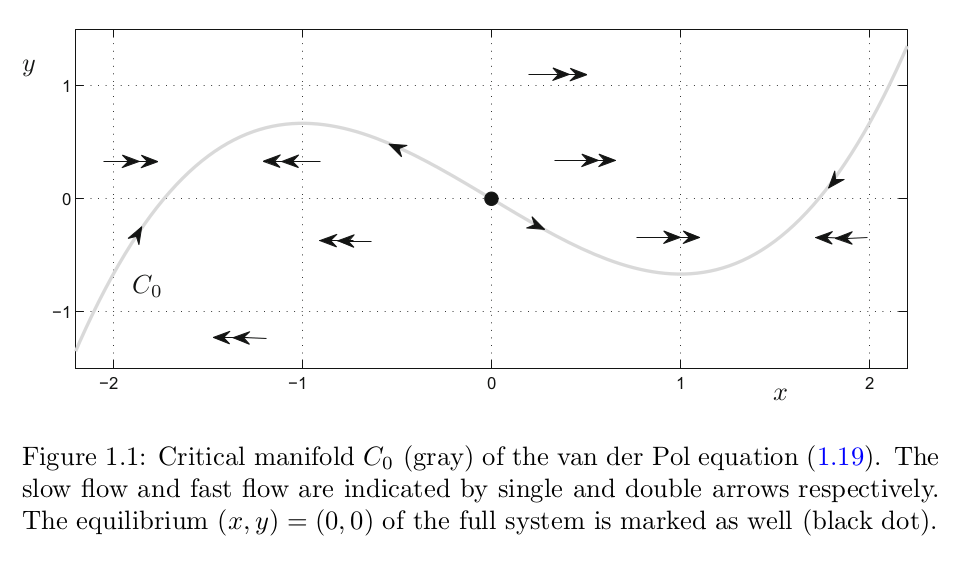


* A _candidate trajectory_ for a fast-slow system is a concatenation of trajectories for the two singular limits, with compatible orientations. 

**Q: when can candidate trajectories be obtained as limits of trajectories for the original system with $\epsilon \neq 0$?**

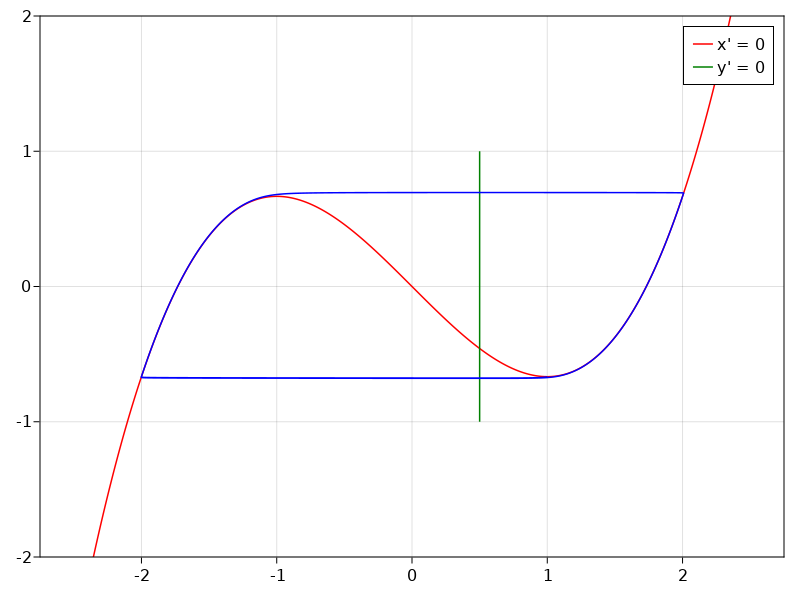

In [71]:
u0 = [1.0,-.667]
tspan = (0.0,5.0)
p = (1e-3,.5)
fig,sol = vdpplot(u0,tspan,p)
fig
ylims!(-2,2)
fig

## II. Normal hyperbolicity and Fenichel theory

* Suppose we have an $(m,n)$-fast-slow system with equations in fast time given as $$x' = f(x,y, \epsilon)$$ $$y' = \epsilon g(x,y,\epsilon)$$ Recall that we have the **critical manifold** $$C_{0} = \{(x,y) \in \mathbb{R}^m \times \mathbb{R}^n \, : \, f(x,y,0) = 0\}$$ 

* We say that the manifold is **normally hyperbolic** at a point $p \in C_0$ if $p$ is a hyperbolic equilibrium of the fast subsystem, equiv. all eigenvalues of $D_x f(p,0)$ have nonzero real part.
    * Example: the critical manifold of the van der Pol oscillator is normally hyperbolic at all points except the two knees/folds.
    * Intuition: at the point $p$, the directions normal to the critical manifold are exponentially expanding or contracting.
    * Context: this definition of normal hyperbolicity only works for fast-slow systems written in the _standard form_. There is a more general definition that fits into the well-developed mathematical theory of _partial hyperbolicity_.

* In line with our intuition from last time that hyperbolicity should associated with perturbation-resistant behavior, we have **Fenichel's theorem**, which says that compact normally hyperbolic submanifolds of the critical manifold perturb to invariant manifolds of the system with $\epsilon$ small but positive.

**Theorem (Fenichel's main theorem [in the fast-slow setting]):** Suppose $S = S_0$ is a compact normally hyperbolic submanifold (possibly with boundary) of the critical manifold $C_0$ and $f$, $g$ are $C^r$. Then, for $\epsilon > 0$ sufficiently small we have:

1. There exists a $C^r$ locally invariant manifold $S_{\epsilon}$ diffeomorphic to $S_0$ (trajectories can enter or leave $S_{\epsilon}$ only through the boundaries).

2. As $\epsilon \to 0$, the Haussdorf distance between $S_{\epsilon}$ and $S_{0}$ scales like $\mathcal{O}(\epsilon)$.

3. As $\epsilon \to 0$, the flow of the full system on $S_{\epsilon}$ converges to the flow of the slow subsystem on $S_{0}$.

4. $S_{\epsilon}$ is also normally hyperbolic and has the same stability properties w.r.t. the fast variables as $S_0$.

5. $S_{\epsilon}$ is usually not unique, but all manifolds satisfying the above properties are "transcendentally close" to one another in Haussdorff distance (as with center manifolds, they have the same "Taylor series")

Any manifold $S_{\epsilon}$ satisfying the properties above is called a **slow manifold** of the system. Moreover, viewing points $p \in S_0$ as equilibria for the fast subsystem, we can define local stable/ unstable manifolds for the set $S_0$ as unions of the local stable/unstable manifolds for each equilibrium:

$$W^{s}_{\text{loc}}(S_0) = \bigcup_{p\in S_0} W^{s}_{\text{loc}}(p)$$
$$W^{u}_{\text{loc}}(S_0) = \bigcup_{p\in S_0} W^{u}_{\text{loc}}(p)$$

The manifolds $W^{s}_{\text{loc}} (S_0)$ and $W^{u}_{\text{loc}} (U_0)$ also persist for $\epsilon >0$ sufficiently small, in the sense that there exist local stable and unstable manifolds $W^{s}_{\text{loc}}(S_{\epsilon})$ and $W^{u}_{\text{loc}} (S_{\epsilon})$ which satisfy the analogs of properties (1)-(5) above.


---


### Example:

Consider the $(1,1)$-fast-slow system given by equations $$x' = y^2 - x$$ $$y' = -\epsilon y$$ The critical manifold is $$C_0 = \{(x,y)\in \mathbb{R}^2 \, : \, x = y^2\}$$ A quick computation shows that $C_0$ is normally hyperbolic and attracting everywhere: since $$\frac{\partial}{\partial x} (y^2 - x) = -1 < 0$$ The ODE can be solved explicitly by $$(x(t), y(t)) = \left( \left[ x(0) - \frac{y(0)^2}{1-2\epsilon} \right] e^{-t} + \frac{y(0)^2}{1-2\epsilon} e^{-2\epsilon t}, y(0) e^{-\epsilon t} \right)$$ If we assume $x(0) = y(0)^2 / (1-2\epsilon)$, then the solution evolves only on the slow time scale and lies on the manifold $x = y^2 / (1-2\epsilon)$. Thus, the slow manifold is $$C_{\epsilon} = \left\{ (x,y) \in \mathbb{R}^2 \, : \, x= \frac{y^2}{1-2\epsilon} \right\}$$

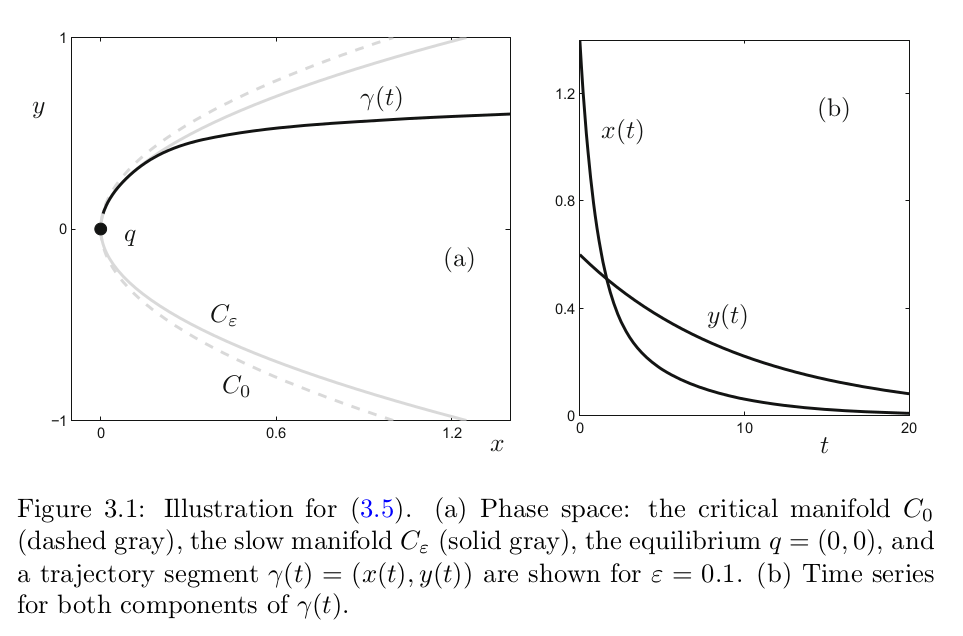

* The above example is atypical: usually not feasible to compute the slow manifolds analytically (and difficult to do so numerically)

* Fenichel's theorem as written above is really a corollary of a more general _global center manifold_ result that he proved. This result gives existence of invariant manifolds (e.g. center manifolds etc.) for submanifolds consisting wholly of equilibria (rather than just for a single equilibrium). We may end up referring to the more general theorem later.

* **Key takeaway/recap**: Compact normally hyperbolic submanifolds of the critical manifold persist for small $\epsilon > 0$. In particular, compact candidate trajectories of the slow subsystem perturb to actual trajectories of the original system.

* Note that Fenichel's theorem gives us no information about _non-normally hyperbolic points_, which as we've already seen certainly arise in systems of interest e.g. the van der Pol oscillator. Indeed, these points are where there is a switch between the fast and slow dynamics, and in general where interesting dynamics are born. Fenichel theory alone will not be enough.

---

One definition before we proceed: non-normally hyperbolic points are analogous to bifurcation points, and we can taxonomize (is this a word?) them similarly. In particular, we say a point $p \in \mathbb{R}^{m+n}$ on the critical manifold is a **fold point** if $$f(p,0) = 0$$ $$(D_{x} f)(p,0) \text{ has rank } m-1$$ It is **nondegenerate** if, for $v$, $w$ nonzero vectors in the left and right zero eigenspaces of $(D_x f)(p,0)$, we have $$w \cdot [(D_{xx} f)(p,0)(v,v)] \neq 0$$ $$w \cdot [(D_{y} f)(p,0)]\neq 0$$ We have not just written down random conditions -- recall that these are precisely the nondegeneracy conditions required for a saddle-node bifurcation to occur in the fast subsystem.

## III. Blowing stuff up

* The **blowup method**, co-opted from algebraic geometry, is one very useful technique for coping with nonhyperbolic equilibria. It allows to construct a vector field with hyperbolic singularities out of a vector field lacking them.

* Motivating example: consider the system $$\dot{x} = x^2 - 2xy$$ $$\dot{y} = y^2 -2xy$$ The equilibrium at $(0,0)$ is very degenerate: note that the Jacobian evaluates to $$ \begin{pmatrix} 2x-2y && -2x \\ -2x && 2y-2x \end{pmatrix} \Big\vert_{(0,0)} = \begin{pmatrix} 0 & 0 \\ 0 & 0 \end{pmatrix}$$ Suppose we evaluate the vector field along the line $(r \cos(\theta), r\sin(\theta))$ for some fixed $\theta$: we find $\dot{x} = r^2 (\cos^2 (\theta) - \cos(\theta) \sin(\theta))$ and $\dot{y} = r^2 (\sin^2 (\theta) - \cos(\theta) \sin(\theta)$. As $r\to 0$, the magnitude of the vector approaches $0$, but the direction remains constant. This suggests that the prefactor of $r^2$ is "masking" some limiting picture as $r\to 0$.

* More precisely, consider the **polar blowup map** $\Psi : S^1 \times \mathbb{R} \to \mathbb{R}^2$ given by $$\Psi(\theta, r) = (r\cos(\theta), r\sin(\theta))$$ This is just the change-of-variables map from polar to rectangular coordinates. For $r\neq 0$, it is a diffeomorphism onto its image. However, the preimage of the origin in $\mathbb{R}^2$ is not a single point, but a full circle of points. The map "resolves" the directions near the origin. In higher dimensions, the **blowup map** is $\Psi : S^n \times \mathbb{R} \to \mathbb{R}^{n+1}$ given by $$\Psi(x_1, \cdots, x_n, r) = (rx_1, rx_2, \cdots, rx_n)$$

* Given a vector field $F$ on $\mathbb{R}^2 \setminus \{(0,0)\}$, we can pull it back along the polar blowup to obtain a vector field $\tilde{F}$ on $S^1 \times (\mathbb{R} \setminus \{0\})$. In the current example, this gives $$\tilde{F}(\theta, r) = (D\Psi^{-1} \circ F \circ \Psi)(\theta, r) = \begin{pmatrix} -\sin(\theta)/r && \cos(\theta)/r \\ \cos(\theta) && \sin(\theta) \end{pmatrix} \cdot \begin{pmatrix} r^2 (\cos^2(\theta)- 2 \cos(\theta) \sin(\theta)) \\ r^2 (\sin^2 (\theta) - 2 \cos(\theta) \sin(\theta))\end{pmatrix}$$ $$ = \begin{pmatrix} 3r \cos(\theta) \sin(\theta) (\sin(\theta) - \cos(\theta)) \\ \frac{1}{4} r^2 (\cos(\theta) + 3\cos(3\theta) + \sin(\theta) - 3\sin(3\theta)) \end{pmatrix}$$ Crucially, note that if divide both components by $r$, we do not change the qualitative structure of the phase portrait at all (although we do change how long the trajectory spends near each point). Thus, we can instead consider $$\tilde{F}_{ds}(\theta, r) = \begin{pmatrix} 3 \cos(\theta) \sin(\theta) (\sin(\theta) - \cos(\theta)) \\ \frac{1}{4} r (\cos(\theta) + 3\cos(3\theta) + \sin(\theta) - 3\sin(3\theta)) \end{pmatrix}$$ This vector field extends _nontrivially_ to $S^1 \times \{0\}$.

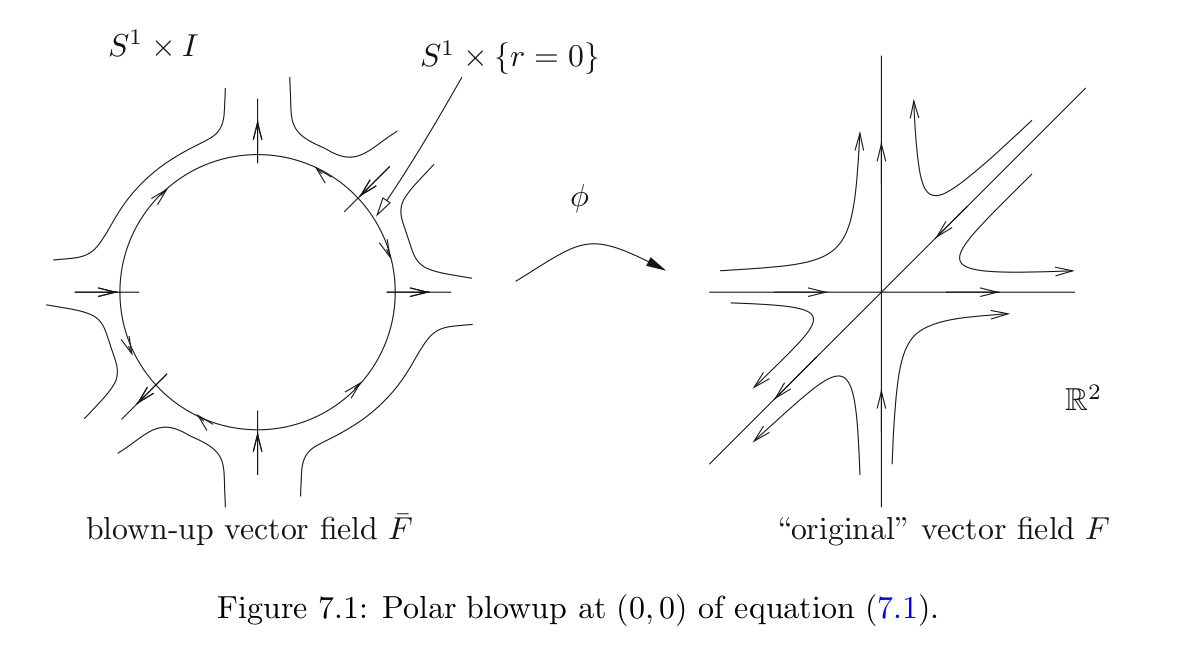

* It turns out that the desingularized vector field has six equilibria on the circle $S^1 \times \{0\}$, all of which are _hyperbolic saddle points_. This implies, for example, that the origin is an unstable equilibrium of the original vector field $F$, a result which is not apparent from linear stability analysis, or even a center manifold reduction!

* Using Fenichel theory in conjunction with the blowup method, one can show that the candidate trajectory we built earlier for the van der Pol oscillator does indeed perturb to a real limit cycle for sufficiently small $\epsilon > 0$. Details are found in Krupa, Szmolyan 2001.

* To illustrate the blowup method in practice, we will actually use a different example, the autocatalator analyzed in Gucwa, Szmolyan 2008.

* It has been shown by Dumortier that any analytic planar vector field can be desingularized fully (i.e. all equilibria made hyperbolic) by a finite sequence of (possibly repeated) blowups; no analogous statement is known for arbitrary dimensions, but the technique still generalizes for use in specific examples.

---


### Directional blowups

In order to facilitate working with vector fields on $S^n \times \mathbb{R}$, it will be convenient to introduce _charts_ that cover the space and on which the blowup map takes an especially simple form. This precisely amounts to passing to the standard affine coordinate charts on projective space in algebraic geometry.

We define the chart $K_{i, \pm} : \mathbb{R}^{n+1} \to S^n \times \mathbb{R}$ as $$K_{i, \pm} (x_0, x_1, x_2, \cdots, x_{i-1}, r_i, x_{i+1}, \cdots, x_n) = \left(\frac{x_0}{q_{i}}, \frac{x_1}{q_{i}}, \cdots,\pm q_{i}, \cdots, \frac{x_{n}}{q_{i}}, r_i q_i \right)$$ This messy formula is a slight modification of the standard coordinate chart on $S^n$ that one obtains when projecting a hemisphere in the $i$th coordinate direction (i.e. $S^n \cap \{\pm x_i > 0\}$) radially onto the hyperplane $x_i = \pm 1$.

The more important fact is that in these charts, the blowup map takes an especially simple form, namely we have the **directional blowup maps** $\Psi_{i, \pm} := \Psi \circ K_{i, \pm}$ given by $$\Psi_{i, \pm} (x_0, x_1, \cdots, r_i, \cdots, x_n) = (r_i x_0, r_i x_1, \cdots, \pm r_i, \cdots, r_i x_n)$$ This is exactly the map obtained by setting $x_i = \pm 1$ in the standard blowup map.

## IV. The autocatalator (Gucwa, Szmolyan 2008)

* Gucwa and Szmolyan consider the planar system given by $$\dot{a} = \mu - a - ab^2$$ $$\epsilon \dot{b} = -b + a + ab^2$$ This is a model of an autocatalytic chemical reaction, and thus we assume $a, b \ge 0$ (the variables represent concentrations).

* We begin the analysis by simply identifying the key players: $a$ is slow, $b$ is fast. The slow subsystem is $$\dot{a} = \mu - a - ab^2$$ $$-b + a + ab^2 = 0$$ and the fast subsystem is $$\dot{b} = -b + a + ab^2$$ $$\dot{a} = 0$$ The critical manifold is $C_0 = \{(a,b) \, : \, -b + a + ab^2 = 0 \} = \left\{(a,b) \, : \, a = \frac{b}{1+b^2} \right \}$. There is a nondegenerate fold point at $p_{f} = (1/2, 1)$.

* For each $0<a<1/2$, there are two equilibria of the corresponding fast subsystem layer, and we can compute that their stability depends on the sign of $(b^2 - 1)/(b^2 + 1)$. Thus, the branch of equilibria with $b<1$ is attracting and the branch with $b>1$ is repelling.

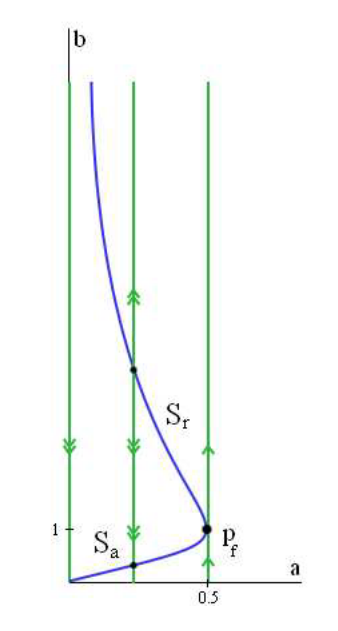

* Now, consider the slow subsystem; a computation shows that subject to the algebraic constraint, $b$ satisfies the 1D equation $$\dot{b} = \frac{(1+b^2)^2}{1-b^2} (\mu - b)$$ We will restrict attention to the case $\mu > 1$. In this case, the slow flow has an unstable equilibrium at $b = \mu$. 

* Based on this analysis, we expect that for initial conditions to the left of the critical manifold, the trajectory will rapidly get attracted to the bottom branch, then creep upwards until it reaches the fold point. At the fold point, we expect it to jump off to infinity.

* Let's now simulate the system to see if this is indeed what happens.

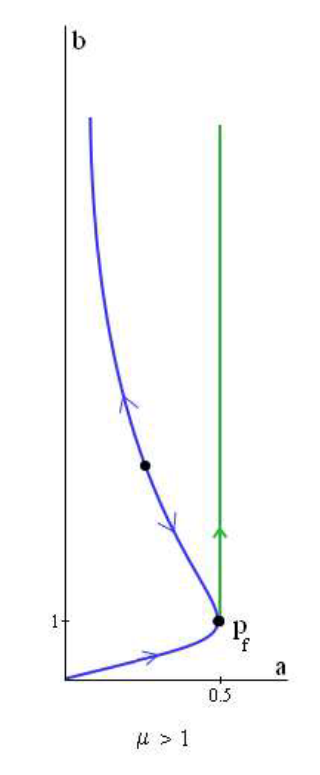

In [123]:
u0 = zeros(2)
tspan = (0.0,30.0)
p = (1e-4, 1.3)
sol = gstr(u0, tspan, p);

bs = 0:.1:100
as = bs ./ (1 .+ bs.^2);

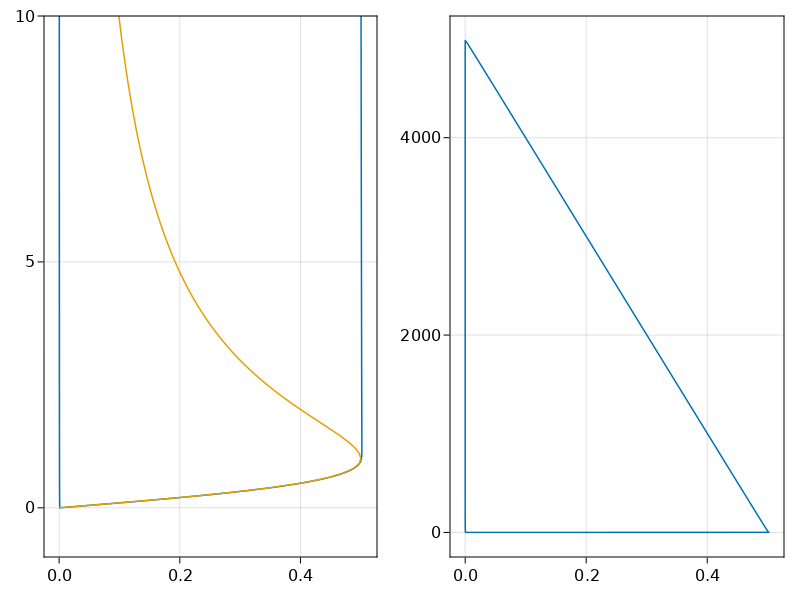

In [135]:
fig, ax, pl = lines(sol[1,:], sol[2,:])
lines!(as,bs)
ylims!(-1,10)
current_figure()
ax2 = Axis(fig[1,2])
lines!(ax2, sol[1,:], sol[2,:])
fig

**Q:** What causes the trajectory to slowly veer towards the $b$-axis, and why wasn't it captured by our analysis?